In [1]:

import glob
import librosa, os
import numpy as np

from glob import glob1
from keras.utils import Sequence

from utils import complex_to_polar, polar_to_complex

class Train_Generator(Sequence) : 
    def __init__(self, src_path, batch_size, n_fft=1918, win_length=1024, unit_bulk=6, shuffle=False) -> None:
        if src_path[:-1] != "/" : src_path += "/"
        
        self.input_path_list = [src_path + merge for merge in glob1(dirname=src_path, pattern="merge*")]
        self.output_voice_path_list = [src_path + voice for voice in glob1(dirname=src_path, pattern="voice*")]
        self.output_music_path_list = [src_path + music for music in glob1(dirname=src_path, pattern="music*")]

        self.input_path_list = sorted(self.input_path_list)
        self.output_voice_path_list = sorted(self.output_voice_path_list)
        self.output_music_path_list = sorted(self.output_music_path_list)
        
        assert len(self.input_path_list) == len(self.output_voice_path_list) \
            and len(self.output_voice_path_list) == len(self.output_music_path_list), AssertionError("The number of source sample must be same. : [{}, {}, {}]".format(
            len(self.input_path_list), len(self.output_voice_path_list), len(self.output_music_path_list)
            ))

        self.sample_rate_list = []
        self.batch_size = batch_size
        self.unit_bulk = unit_bulk
        self.n_fft = n_fft
        self.win_length = win_length

        for path in self.input_path_list : 
            self.sample_rate_list.append(librosa.get_samplerate(path))
        
        self.src_index_list = [i for i in range(len(self.input_path_list))]

        if shuffle : 
            from numpy import random
            random.shuffle(self.src_index_list)
        
        train_input, train_output1, train_output2 = self.load_data(0)
        self.index_count = 0

        self.x = train_input
        self.y = [train_output1, train_output2]
        self.prev_batch_index = 0
    
    def load_data(self, src_index) -> list: 
        """Return a list of data in `self.path[src_index]`.
            - `self.input_path_list`
            - `self.output_voice_path_list`
            - `self.output_music_path_list`

        Return as a polar-coordinated data, with shape of `(-1, n_fft / 2 + 1, 64 * unit_bulk, 2)`
        
        ---
        Args:
            `src_index` : the index of `path_list`. use the data in `self.path[src_index]`,

        Returns:
            `Data_list` : `merged_data`, `voice_data`, `music_data`
        """
        merge_path = self.input_path_list[src_index]
        voice_path = self.output_voice_path_list[src_index]
        music_path = self.output_music_path_list[src_index]

        Data_list = []
        for path in [merge_path, voice_path, music_path] : 
            source = librosa.load(path=path, sr=self.sample_rate_list[src_index])[0]
            D_raw = librosa.stft(source, n_fft=self.n_fft, win_length=self.win_length)
            
            quotient = int(len(D_raw[0,:]) // (64 * self.unit_bulk))
            assert quotient >= 1, AssertionError(
                "Data source is too short to slice with unit_bulk : [{} : {} - {}]".format(path, len(D_raw[0,:]), 64 * self.unit_bulk)
            )

            D_slice = D_raw[:,:int(quotient * (64 * self.unit_bulk))].copy()
            D_slice = D_slice.reshape((-1, int(self.n_fft / 2 + 1), int(64 * self.unit_bulk)))
            Data_list.append(complex_to_polar(D_slice))

            del D_raw

        return Data_list
    
    def __len__(self):
        return int(len(self.x) / self.batch_size)
    
    def __getitem__(self, index):
        if len(self.x) < self.prev_batch_index + self.batch_size : 
            batch_x = self.x[self.prev_batch_index:]
            batch_y1 = self.y[0][self.prev_batch_index:]
            batch_y2 = self.y[1][self.prev_batch_index:]

            self.prev_batch_index = len(self.x)

            return batch_x, [batch_y1, batch_y2]

        else : 
            batch_x = self.x[self.prev_batch_index:self.prev_batch_index + self.batch_size]
            batch_y1 = self.y[0][self.prev_batch_index:self.prev_batch_index + self.batch_size]
            batch_y2 = self.y[1][self.prev_batch_index:self.prev_batch_index + self.batch_size]

            self.prev_batch_index += self.batch_size

            return batch_x, [batch_y1, batch_y2]
    
    def on_epoch_end(self):
        del self.x, self.y[1], self.y[0]

        if self.index_count + 1 >= len(self.input_path_list) : 
            self.index_count = 0
        else : self.index_count += 1

        train_input, train_output1, train_output2 = self.load_data(self.index_count)

        self.x = train_input
        self.y = [train_output1, train_output2]
        self.prev_batch_index = 0
    
    @property
    def input_shape(self) : 
        return self.x.shape[1:]


In [2]:
from utils import gen_dataset

target_dir = "./test_dir"

gen_dataset(target_dir, train_test_split=0.6)


Processing... [|] : [003/006]

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


Processing... [|] : [006/006]	  Done


In [3]:
train_path = "./test_dir/train_data/"

batch_size = 6
train_generator = Train_Generator(src_path=train_path, batch_size=batch_size)

print(train_generator.input_shape)

(960, 384, 2)


In [4]:
from utils import gen_separate_unet

temp_model = gen_separate_unet(input_shape=train_generator.input_shape)
temp_model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 960, 384, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 192, 32  1632        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 480, 192, 32  1632        ['input_1[0][0]']                
             

In [5]:
temp_model.compile(optimizer="adam", loss="mae")
history = temp_model.fit(x=train_generator, epochs=6, verbose=1)

Epoch 1/6


2023-07-18 16:42:10.973167: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


30/30 [==============================] - 46s 1s/step - loss: 1.4181 - vocal_separation_loss: 0.7129 - separation_1_loss: 0.7052
Epoch 2/6
30/30 [==============================] - 29s 954ms/step - loss: 1.7088 - vocal_separation_loss: 0.7371 - separation_1_loss: 0.9718
Epoch 3/6
30/30 [==============================] - 17s 552ms/step - loss: 1.4327 - vocal_separation_loss: 0.7738 - separation_1_loss: 0.6589
Epoch 4/6
30/30 [==============================] - 44s 1s/step - loss: 1.5618 - vocal_separation_loss: 0.7552 - separation_1_loss: 0.8067
Epoch 5/6
30/30 [==============================] - 30s 956ms/step - loss: 1.6644 - vocal_separation_loss: 0.7350 - separation_1_loss: 0.9293
Epoch 6/6
30/30 [==============================] - 18s 558ms/step - loss: 1.3950 - vocal_separation_loss: 0.7704 - separation_1_loss: 0.6246


In [7]:
print(history.history.keys())

dict_keys(['loss', 'vocal_separation_loss', 'separation_1_loss'])


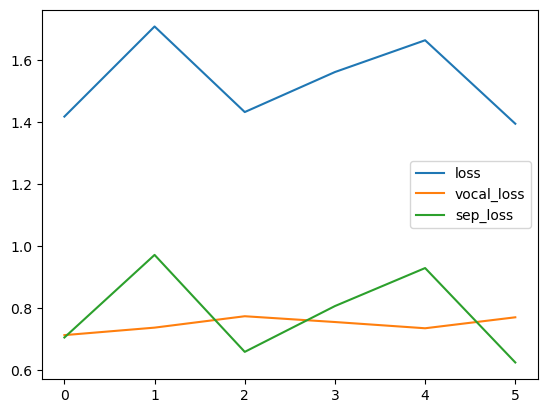

In [9]:
import matplotlib.pyplot as plt


epoch = history.epoch

loss = history.history["loss"]
vocal_loss = history.history["vocal_separation_loss"]
sep_loss = history.history["separation_1_loss"]

plt.plot(epoch, loss, label="loss")
plt.plot(epoch, vocal_loss, label="vocal_loss")
plt.plot(epoch, sep_loss, label="sep_loss")
plt.legend()
plt.show()
